# Set up parameters that will be inherited to plot background topo maps, on top of which other maps will be created

In [1]:


from pathlib import Path
import numpy as np
import pandas as pd
from obspy import read, read_inventory
from importlib import reload
import flovopy.processing.envelopes as env
import flovopy.asl.envelope_locate as envloc
reload(env)
reload(envloc)
from flovopy.processing.envelopes import (
    align_waveforms,
    align_waveforms_global,
    envelopes_stream,
    envelope_delays,
    locate_with_grid_from_delays,
)
from flovopy.asl.envelope_locate import process_event, summarize_suite, parse_lags_column, \
    compute_pairwise_diffs, summarize_pairwise, estimate_speed_from_stable_pairs, plot_speed_vs_distance
from flovopy.asl.grid import Grid
from flovopy.asl.wrappers2 import find_event_files
from flovopy.core.mvo import dome_location

# -------------------------- Config --------------------------
PROJECTDIR      = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR      = f"{LOCALPROJECTDIR}/asl_results"
INPUT_DIR       = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
GLOBAL_CACHE    = f"{PROJECTDIR}/asl_global_cache"

INVENTORY_XML   = "/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT     = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")
GRIDFILE_DEFAULT= "/Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl"

SMOOTH_SECONDS  = 1.0
MAX_LAG_SECONDS = 8.0
MIN_XCORR       = 0.5
best_file_nums  = [35, 36, 40, 52, 82, 83, 84, 116, 310, 338]

INV     = read_inventory(INVENTORY_XML)
gridobj = Grid.load(GRIDFILE_DEFAULT)
input_dir = Path(INPUT_DIR)
event_files = list(find_event_files(input_dir))
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("Dome (assumed source) =", dome_location)

# -------------------------- Run suite --------------------------
rows = []
per_event_lags = []  # store detailed lags to print later

for file_num in best_file_nums:
    try:
        event_path = str(event_files[file_num])
    except Exception as e:
        print(f"[WARN] file_num={file_num} not found in event_files list: {e}")
        continue

    eventdir       = Path(OUTPUT_DIR) / str(file_num)
    score_vs_c_png = str(eventdir / "score_vs_c.png")
    ccf_plot_dir   = str(eventdir / "ccf_plots")
    topo_png       = str(eventdir / "best_location_topo.png")
    eventdir.mkdir(parents=True, exist_ok=True)

    print(f"\n=== Event {file_num} ===")
    try:
        st = read(event_path).select(component="Z")
    except Exception as e:
        print(f"[ERROR] read failed for {event_path}: {e}")
        continue
    st.merge(fill_value="interpolate")
    st.detrend("linear")

    # Per-event
    res = process_event(st, gridobj, INV, GLOBAL_CACHE, dome_location, smooth_s=1.0, max_lag_s=8.0,
                min_corr=0.5, c_range=(0.1, 5.0), event_idx=file_num,
                output_dir=OUTPUT_DIR,           # <-- needed for score_vs_c.png
                topo_dem_path=DEM_DEFAULT,
           )       # optional, keeps topo plot
        # keep your Stage-A knobs here if you want to tweak:
        # min_delta_d_km=0.5, min_abs_lag_s=0.15, delta_d_weight=True, c_phys=(0.5,3.5)
    print(res)
    print(res["locator_result"]["speed"])
    rows.append(res["summary_row"])  

# ---------------- Suite summary -> stable pairwise -> speed & plot ----------------

# 1) Build the suite summary DataFrame and save it
df = summarize_suite(rows, f"{OUTPUT_DIR}/suite_summary.csv")
print("suite_summary columns:", list(df.columns))
print(df)

# 2) Parse per-event lags (prefer the global set; fall back if needed)
lags_col = (
    "lags_global" if "lags_global" in df.columns else
    ("lags_glb" if "lags_glb" in df.columns else None)
)
if lags_col is None:
    raise KeyError("No lags column found in suite summary (expected 'lags_global' or 'lags_glb').")

lags_glb = parse_lags_column(df[lags_col])          # -> list[dict{STA: lag_s}]
pairdiffs = compute_pairwise_diffs(lags_glb)        # -> list[dict{(STA,STA): dτ}]
stable_glb = summarize_pairwise(pairdiffs, "global")# -> DataFrame with sta_a/sta_b, mean_s, median_s, std, mad, ...

# Save the stable pairs (nice to keep for reproducibility)
stable_csv = Path(OUTPUT_DIR) / "pairwise_lagdiff_stats_global_stable.csv"
stable_glb.to_csv(stable_csv, index=False)
print(f"[stable] wrote -> {stable_csv}  (rows={len(stable_glb)})")

if stable_glb.empty:
    raise ValueError("Stable global pairwise table is empty — check your lags parsing and MAD filter.")

# 3) Estimate speed directly from the DataFrame (no need to re-read CSV)
res = estimate_speed_from_stable_pairs(
    grid=gridobj,
    inventory=INV,
    cache_dir=GLOBAL_CACHE,
    dome_location=dome_location,
    stable_df=stable_glb,         # <— pass the DataFrame
    use_value="mean_s",           # or "median_s"
    weight_with="mad_scaled",     # or "std" or None
    min_delta_d_km=0.0,           # relax if you want to keep all geometry
    min_abs_tau_s=0.0,
    c_bounds=(0.2, 7.0),
    uncert_floor_s=0.05,
)

print(f"Speed ≈ {res['speed_km_s']:.3f} km/s  (68% CI {res['ci_68'][0]:.3f}–{res['ci_68'][1]:.3f}) "
      f"using {res['n_pairs_used']} pairs")

per_pair = res["per_pair"]   # -> has delta_d_km, c_pair_km_s, weight

print(f"Speed (robust): {res['speed_km_s']:.3f} km/s "
      f"(68% CI {res['ci_68'][0]:.3f}-{res['ci_68'][1]:.3f}), "
      f"pairs used: {res['n_pairs_used']}")

# 4) Plot apparent speed vs Δd with a straight-line fit (intercept fixed at 0.5 km/s)
plot_speed_vs_distance(res, intercept=0.5, cmax=7.0)   # accepts dict OR res["per_pair"]

[INFO] Grid loaded from /Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl
Dome (assumed source) = {'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}

=== Event 35 ===
[COMPUTE OR LOAD DISTANCES] Computing fresh distances…


/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
[COMPUTE OR LOAD DISTANCES] Computing fresh distances…
{'lags_ref': {'MBBY': 0.0, 'MBGB': 0.08, 'MBGH': 0.41333333333333333, 'MBMH': 3.6, 'MBRY': 1.6933333333333334, 'MBSS': -0.5466666666666666, 'MBWH': 1.0266666666666666}, 'lags_global': {'MBBY': 0.0, 'MBGB': 1.5675798148441422, 'MBGH': 1.0993643127885901, 'MBMH': 0.5936341145759558, 'MBRY': 1.3815725855267476, 'MBSS': 1.2350862685819213, 'MBWH': 0.350131021381273}, 'delays': {('MBBY', 'MBGB'): (-0.08, 0.8771965647144637), ('MBBY', 'MBGH'): (-0.41333333333333333, 0.8716505267665786), ('MBBY', 'MBMH'): (-3.6, 0.8794738812755666), ('MBBY', 'MBRY'): (-1.6933333333333334, 0.698483590104738), ('MBBY', 'MBSS'): (0.5466666666666666, 0.8716819874776092), ('MBBY', 'MBWH'): (-1.0266666666666666, 0.8783292819864521), ('MBGB', 'MBGH'): (-0.7733333333333333, 0.8688763173049464), ('MBGB', 'MBMH'): (3.7733333333333334, 0.8712879814440309), ('MBGB', 'MBRY'): (2.6666666666666665, 0.7264905678794874), (

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 0.5733333333333334, 'MBGH': 0.92, 'MBMH': 2.4266666666666667, 'MBRY': 1.7466666666666666, 'MBSS': -0.44, 'MBWH': 0.37333333333333335}, 'lags_global': {'MBBY': 0.0, 'MBGB': 0.5294276872965406, 'MBGH': 1.0339224944550627, 'MBMH': 2.204072569352858, 'MBRY': 1.7050636644033261, 'MBSS': -0.45477627347901395, 'MBWH': 0.5809310992727011}, 'delays': {('MBBY', 'MBGB'): (-0.5733333333333334, 0.8350494716244051), ('MBBY', 'MBGH'): (-0.92, 0.8170186503976702), ('MBBY', 'MBMH'): (-2.4266666666666667, 0.869451578063575), ('MBBY', 'MBRY'): (-1.7466666666666666, 0.7124307702206933), ('MBBY', 'MBSS'): (0.44, 0.8249675468948745), ('MBBY', 'MBWH'): (-0.37333333333333335, 0.8620062805219755), ('MBGB', 'MBGH'): (-0.7333333333333333, 0.8360172448953432), ('MBGB', 'MBMH'): (-1.5333333333333334, 0.8847458362025153), ('MBGB', 'MBRY'): (-1.28, 0.7460888541038425), ('MBGB', 'MBSS'): (1.5733333333333333, 0.8882226031714068), ('MB

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 3.1066666666666665, 'MBGH': 2.3466666666666667, 'MBLG': 3.48, 'MBMH': 1.08, 'MBRY': -0.3466666666666667, 'MBSS': -0.4, 'MBWH': 1.6666666666666667}, 'lags_global': {'MBBY': 0.0, 'MBGB': 1.5775958159162171, 'MBGH': 1.8518825524604594, 'MBLG': 3.0351220950274582, 'MBMH': 1.7335641528515644, 'MBRY': 0.5208094695197661, 'MBSS': 1.451889696268997, 'MBWH': 0.7296026241042134}, 'delays': {('MBBY', 'MBGB'): (-3.1066666666666665, 0.9018204690802), ('MBBY', 'MBGH'): (-2.3466666666666667, 0.8501294723628097), ('MBBY', 'MBLG'): (-3.48, 0.7507670026464466), ('MBBY', 'MBMH'): (-1.08, 0.8485676301684021), ('MBBY', 'MBRY'): (0.3466666666666667, 0.818553847226341), ('MBBY', 'MBSS'): (0.4, 0.8478078465093554), ('MBBY', 'MBWH'): (-1.6666666666666667, 0.7482288247513816), ('MBGB', 'MBGH'): (-0.13333333333333333, 0.8607069169665038), ('MBGB', 'MBLG'): (0.44, 0.783865951207625), ('MBGB', 'MBMH'): (-0.6133333333333333, 0.8535

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGB': 0.28, 'MBGH': 3.64, 'MBMH': -0.25333333333333335, 'MBRY': 1.2, 'MBSS': -1.9733333333333334, 'MBWH': 1.44}, 'lags_global': {'MBBY': 0.0, 'MBGB': 1.2016205991211288, 'MBGH': 2.3328697223254955, 'MBMH': 1.9471754406558408, 'MBRY': 1.195004157858157, 'MBSS': -0.76730145294233, 'MBWH': -1.6926157558551977}, 'delays': {('MBBY', 'MBGB'): (-0.28, 0.8790006395710964), ('MBBY', 'MBGH'): (-3.64, 0.8822090646467786), ('MBBY', 'MBMH'): (0.25333333333333335, 0.8876107702364313), ('MBBY', 'MBRY'): (-1.2, 0.8980464745092627), ('MBBY', 'MBSS'): (1.9733333333333334, 0.8763389517152201), ('MBBY', 'MBWH'): (-1.44, 0.849942867911873), ('MBGB', 'MBGH'): (0.76, 0.8686277988975866), ('MBGB', 'MBMH'): (1.9333333333333333, 0.8723782745704977), ('MBGB', 'MBRY'): (-0.92, 0.872619838918174), ('MBGB', 'MBSS'): (-0.3466666666666667, 0.8538820280892577), ('MBGB', 'MBWH'): (2.44, 0.8450816969100272), ('MBGH', 'MBMH'): (-0.693333333333

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBFL': -4.91, 'MBFR': -3.8, 'MBGB': -2.58, 'MBGH': 1.33, 'MBHA': -1.42, 'MBLG': -2.26, 'MBLY': -1.08, 'MBRV': -1.57, 'MBRY': 2.14, 'MBWH': -0.7}, 'lags_global': {'MBBY': 0.0, 'MBFL': -3.3863931237414486, 'MBFR': -2.9251793380740545, 'MBGB': -1.7463217150676327, 'MBGH': 1.3522630109832514, 'MBHA': -1.1122694744799426, 'MBLG': -1.9481291462941162, 'MBLY': -1.6227305278244348, 'MBRV': -0.8705678700468432, 'MBRY': -0.9315243623875178, 'MBWH': -1.6034873547913924}, 'delays': {('MBBY', 'MBFL'): (4.91, 0.8755651323583112), ('MBBY', 'MBFR'): (3.8, 0.8793921929294042), ('MBBY', 'MBGB'): (2.58, 0.860039060149102), ('MBBY', 'MBGH'): (-1.33, 0.8803887832306339), ('MBBY', 'MBHA'): (1.42, 0.8443840283390152), ('MBBY', 'MBLG'): (2.26, 0.8855417563693798), ('MBBY', 'MBLY'): (1.08, 0.8984857002005571), ('MBBY', 'MBRV'): (1.57, 0.8229222291232544), ('MBBY', 'MBRY'): (-2.14, 0.8831422338167368), ('MBBY', 'MBWH'): (0.7, 0.831545

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBFL': -2.19, 'MBFR': -0.0, 'MBGB': 3.09, 'MBGH': 0.67, 'MBLG': -3.09, 'MBLY': -0.07, 'MBRV': -6.76, 'MBRY': -2.6, 'MBWH': -1.09}, 'lags_global': {'MBBY': 0.0, 'MBFL': -2.2960537311214377, 'MBFR': -0.2572738290087382, 'MBGB': -0.31288666883184585, 'MBGH': 0.5652835843922532, 'MBLG': -1.8770831724944006, 'MBLY': -0.7309594652715589, 'MBRV': -4.392937440027977, 'MBRY': -0.9120919328013625, 'MBWH': -0.869663376663144}, 'delays': {('MBBY', 'MBFL'): (2.19, 0.7915089124393213), ('MBBY', 'MBFR'): (0.0, 0.8522016159010447), ('MBBY', 'MBGB'): (-3.09, 0.8324059230765185), ('MBBY', 'MBGH'): (-0.67, 0.8486858731596923), ('MBBY', 'MBLG'): (3.09, 0.8224506493165008), ('MBBY', 'MBLY'): (0.07, 0.8454129257131736), ('MBBY', 'MBRV'): (6.76, 0.5355533723492429), ('MBBY', 'MBRY'): (2.6, 0.7888316526712517), ('MBBY', 'MBWH'): (1.09, 0.8473480299140157), ('MBFL', 'MBFR'): (-0.66, 0.7894121783800417), ('MBFL', 'MBGB'): (-2.18, 0.78

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBFL': 1.41, 'MBFR': -0.86, 'MBGB': -0.42, 'MBGH': 1.79, 'MBHA': -1.06, 'MBLG': 2.09, 'MBRV': -0.56, 'MBRY': 0.02, 'MBWH': -2.82}, 'lags_global': {'MBBY': 0.0, 'MBFL': 0.5893761785898828, 'MBFR': -1.4767428627698653, 'MBGB': -0.7016003001999599, 'MBGH': -0.20888917165297358, 'MBHA': -2.001185555355397, 'MBLG': 4.793479820369984, 'MBRV': 1.5338970849618518, 'MBRY': -0.8274008320815516, 'MBWH': -1.7903396477867606}, 'delays': {('MBBY', 'MBFL'): (-1.41, 0.8269403847465653), ('MBBY', 'MBFR'): (0.86, 0.87063620555675), ('MBBY', 'MBGB'): (0.42, 0.900850028103625), ('MBBY', 'MBGH'): (-1.79, 0.8571825615686256), ('MBBY', 'MBHA'): (1.06, 0.8703663812349153), ('MBBY', 'MBLG'): (-2.09, 0.8165287403450405), ('MBBY', 'MBRV'): (0.56, 0.8003203903436894), ('MBBY', 'MBRY'): (-0.02, 0.8466314774783432), ('MBBY', 'MBWH'): (2.82, 0.811931042282407), ('MBFL', 'MBFR'): (1.78, 0.8471217256167315), ('MBFL', 'MBGB'): (3.33, 0.864846

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBFL': 0.0, 'MBFR': -0.58, 'MBGB': 0.23, 'MBGH': 0.02, 'MBLG': -0.7, 'MBRV': 6.77, 'MBRY': 2.54, 'MBWH': 0.08}, 'lags_global': {'MBFL': 0.0, 'MBFR': 1.5012509103059968, 'MBGB': 1.0390443831825635, 'MBGH': 2.45518693072791, 'MBLG': 2.7019294604517503, 'MBRV': 3.0883754706709476, 'MBRY': 3.4084164065910816, 'MBWH': 1.2175564369476644}, 'delays': {('MBFL', 'MBGB'): (-0.23, 0.6007712214364422), ('MBFL', 'MBGH'): (-0.02, 0.5660279945624059), ('MBFL', 'MBRV'): (-6.77, 0.7061367058680103), ('MBFL', 'MBWH'): (-0.08, 0.646381697149788), ('MBFR', 'MBGB'): (0.93, 0.7326230477490607), ('MBFR', 'MBGH'): (-1.25, 0.7186482704743645), ('MBFR', 'MBLG'): (0.73, 0.7365173376755964), ('MBFR', 'MBRY'): (-3.04, 0.7043332162106621), ('MBFR', 'MBWH'): (-0.8, 0.6958009731566334), ('MBGB', 'MBGH'): (-1.03, 0.7127283802005056), ('MBGB', 'MBLG'): (0.71, 0.756587562291368), ('MBGB', 'MBRY'): (-3.13, 0.6112935141594503), ('MBGB', 'MBWH'): (-1.37, 0.65

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBGB': 0.0, 'MBGH': -2.12, 'MBLG': -2.6533333333333333, 'MBRY': -1.9066666666666667, 'MBSS': -2.04, 'MBWH': -1.5066666666666666}, 'lags_global': {'MBGB': 0.0, 'MBGH': -2.0452083429751817, 'MBLG': -2.301699160593728, 'MBRY': -1.979956150649398, 'MBSS': -1.8462418834373302, 'MBWH': -1.9868182106023038}, 'delays': {('MBGB', 'MBGH'): (2.12, 0.7877735646486064), ('MBGB', 'MBLG'): (2.6533333333333333, 0.6060379019121382), ('MBGB', 'MBRY'): (1.9066666666666667, 0.6947488768766326), ('MBGB', 'MBSS'): (2.04, 0.8920947291146849), ('MBGB', 'MBWH'): (1.5066666666666666, 0.8204812404515054), ('MBGH', 'MBLG'): (1.0266666666666666, 0.5948241416329326), ('MBGH', 'MBRY'): (-0.38666666666666666, 0.7649274205179285), ('MBGH', 'MBSS'): (-0.3466666666666667, 0.8418932731639324), ('MBGH', 'MBWH'): (-0.09333333333333334, 0.829739166926827), ('MBLG', 'MBRY'): (-0.013333333333333334, 0.7262760675662941), ('MBLG', 'MBSS'): (-0.05333333333333334, 0

/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


[MAP] Adding title Best node (red dot) & stations
{'lags_ref': {'MBBY': 0.0, 'MBGH': -0.5333333333333333, 'MBLG': -1.2533333333333334, 'MBMH': 1.2266666666666666, 'MBRY': -1.88, 'MBSS': -0.29333333333333333, 'MBWH': -0.8933333333333333}, 'lags_global': {'MBBY': 0.0, 'MBGH': -0.4005647209277587, 'MBLG': -0.896014195962767, 'MBMH': 0.6772310802461183, 'MBRY': -2.4376917318862854, 'MBSS': 0.5620911947876113, 'MBWH': -1.1714937614611909}, 'delays': {('MBBY', 'MBGH'): (0.5333333333333333, 0.9404943862833436), ('MBBY', 'MBLG'): (1.2533333333333334, 0.944843558401772), ('MBBY', 'MBMH'): (-1.2266666666666666, 0.8907723769283082), ('MBBY', 'MBRY'): (1.88, 0.9222605080384018), ('MBBY', 'MBSS'): (0.29333333333333333, 0.9353766988740041), ('MBBY', 'MBWH'): (0.8933333333333333, 0.9306280178281592), ('MBGH', 'MBLG'): (0.92, 0.93446160887435), ('MBGH', 'MBMH'): (-0.49333333333333335, 0.9023578628775797), ('MBGH', 'MBRY'): (2.066666666666667, 0.9386142127663416), ('MBGH', 'MBSS'): (-1.3866666666666667

TypeError: _wls_fit() got an unexpected keyword argument 'intercept'

In [2]:
print(df)
def _describe(series, name):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty:
        return f"{name}: no finite values"
    return (f"{name}: n={len(s)}, mean={s.mean():.3f}, median={s.median():.3f}, "
            f"std={s.std(ddof=1):.3f}, min={s.min():.3f}, max={s.max():.3f}")

print("\n=== Descriptive stats ===")
print(_describe(df["c_at_dome_kms"], "c @ dome (km/s)"))
print(_describe(df["c_at_bestnode_kms"], "c @ best node (km/s)"))
#print(_describe(df["dome_to_best_km"], "distance: dome→best (km)"))
print(_describe(df["score_bestnode"], "best-node score"))
print(_describe(df["n_pairs_used"], "n_pairs used"))

# Print best time-lags (top |lag|) for each event for both methods
print("\n=== Top lags by |lag| per event ===")
for rec in per_event_lags:
    e = rec["event_idx"]
    ref_top = ", ".join([f"{sta}:{lag:+.2f}s" for sta, lag in rec["top_ref_lags"]])
    glb_top = ", ".join([f"{sta}:{lag:+.2f}s" for sta, lag in rec["top_global_lags"]])
    print(f"[{e}] ref: {ref_top}")
    print(f"[{e}] glb: {glb_top}")

   event_idx  c_at_dome_kms  score_at_dome  c_at_bestnode_kms  score_bestnode  \
0         35       1.154430   0.000000e+00           1.154430        0.519797   
1         36       0.844304   0.000000e+00           0.844304        0.005882   
2         40       1.505092   0.000000e+00           2.317969        0.059454   
3         52       1.105565   1.628831e-16           2.115493        0.000032   
4         82       0.162025   0.000000e+00           1.836709        0.350548   
5         83       0.613190   0.000000e+00           1.016808        0.086693   
6         84       2.737975   0.000000e+00           3.411392        0.345444   
7        116       0.224051   0.000000e+00           0.844304        0.225871   
8        310       0.348101   0.000000e+00           4.813924        0.000000   
9        338       0.100000   0.000000e+00           0.100000        2.463003   

   n_pairs_used  bestnode_lon  bestnode_lat  bestnode_elev_m  \
0             5    -62.158132     16.747922 

TypeError: _wls_fit() got an unexpected keyword argument 'intercept'

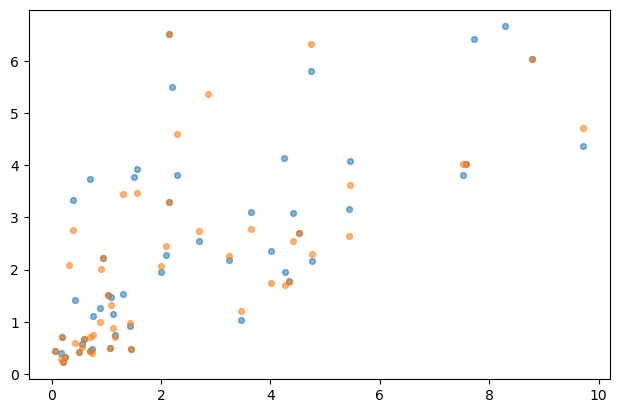

In [2]:
# Load the "stable pairs" CSV produced earlier
stable_csv = f"{OUTPUT_DIR}/pairwise_lagdiff_stats_global_stable.csv"
stab = pd.read_csv(stable_csv)

# Build per-pair tables once for mean_s and once for median_s
pp_mean = envloc.build_per_pair_from_stable(
    grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE, dome_location=dome_location,
    stable_df=stab, use_value="mean_s", c_bounds=(0.2, 7.0)
)
pp_median = envloc.build_per_pair_from_stable(
    grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE, dome_location=dome_location,
    stable_df=stab, use_value="median_s", c_bounds=(0.2, 7.0)
)

# Plot all 6 weighted fits with fixed intercept b=0.5 km/s
envloc.plot_six_weighted_fits(pp_mean, pp_median, intercept=None, cmax=7.0)

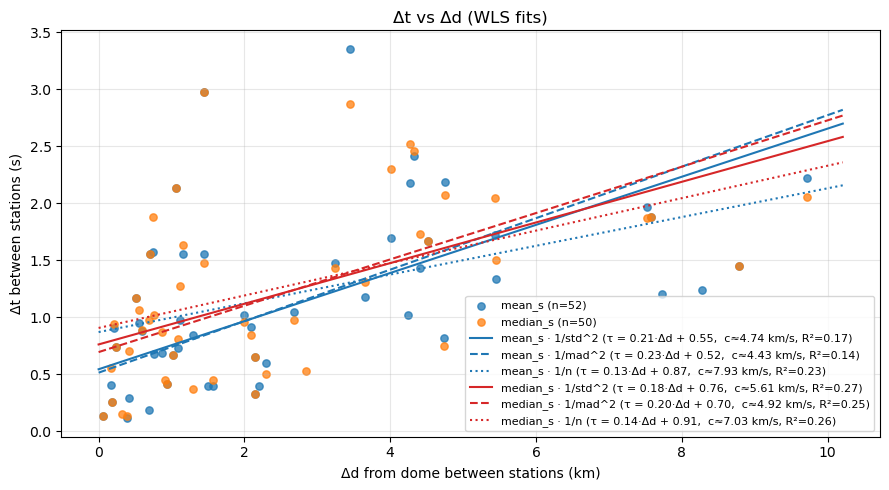

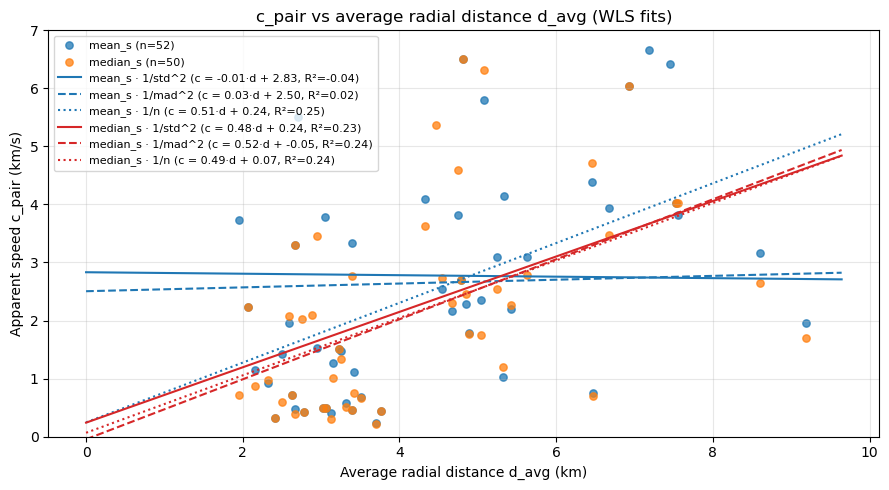

In [3]:
stable_csv = f"{OUTPUT_DIR}/pairwise_lagdiff_stats_global_stable.csv"
stab = pd.read_csv(stable_csv)

# Build per-pair tables once for mean_s and once for median_s
df_mean = envloc.make_pair_geometry_from_stable(
    grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE, dome_location=dome_location,
    stable_df=stab, use_value="mean_s", c_bounds=(0.2, 7.0)
)
df_median = envloc.make_pair_geometry_from_stable(
    grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE, dome_location=dome_location,
    stable_df=stab, use_value="median_s", c_bounds=(0.2, 7.0)
)

# 1) Δt vs Δd with 6 WLS lines (free intercept in τ-space)
envloc.plot_delta_t_vs_delta_d_with_wls(df_mean, df_median, fixed_intercept_tau=None)

# (optional) force τ-intercept to 0 s to visualize bias sensitivity
# plot_delta_t_vs_delta_d_with_wls(df_mean, df_median, fixed_intercept_tau=0.0)

# 2) c_pair vs d_avg with 6 WLS lines (free intercept in c-space)
envloc.plot_cpair_vs_davg_with_wls(df_mean, df_median, fixed_intercept_c=None, cmax=7.0)

# (optional) fix shallow intercept if you want to compare to a hypothesized near-surface speed
# plot_cpair_vs_davg_with_wls(df_mean, df_median, fixed_intercept_c=0.5, cmax=7.0)

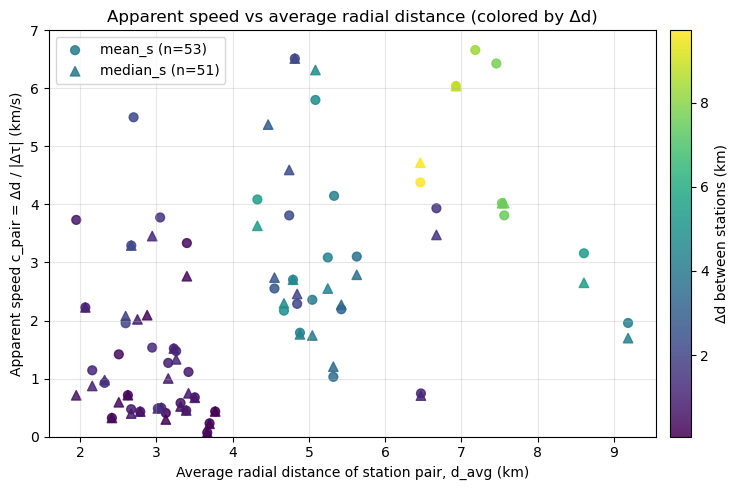

In [4]:
# --- Apparent speed vs average radial distance, colored by Δd ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from flovopy.asl.distances import compute_or_load_distances

# Inputs you already have in your notebook:
# gridobj, INV, GLOBAL_CACHE (or CACHE_DIR), dome_location, OUTPUT_DIR
stable_csv = Path(OUTPUT_DIR) / "pairwise_lagdiff_stats_global_stable.csv"

# 1) Load stable pair table
stab = pd.read_csv(stable_csv)

# Ensure we have sta_a/sta_b (derive from 'pair' if needed) and clean codes
def _clean_sta(x: str) -> str:
    import re
    return re.sub(r"[^A-Za-z0-9]", "", str(x)).upper()

if not {"sta_a", "sta_b"}.issubset(stab.columns):
    if "pair" not in stab.columns:
        raise ValueError("Need 'sta_a'/'sta_b' or a 'pair' column.")
    ab = stab["pair"].astype(str).str.split("-", n=1, expand=True)
    ab.columns = ["sta_a", "sta_b"]
    stab = pd.concat([stab, ab], axis=1)

stab["sta_a"] = stab["sta_a"].apply(_clean_sta)
stab["sta_b"] = stab["sta_b"].apply(_clean_sta)

# 2) Distances from dome to each station (collapse to one vector per station)
node_dists, coords, meta = compute_or_load_distances(
    gridobj,
    cache_dir=(GLOBAL_CACHE if 'GLOBAL_CACHE' in globals() else CACHE_DIR),
    inventory=INV, stream=None, use_elevation=True
)

def _to_sta_key(seed_or_sta: str) -> str:
    parts = str(seed_or_sta).split(".")
    return parts[1] if len(parts) >= 2 else str(seed_or_sta)

dist_by_sta = {}
for full_id, vec in node_dists.items():
    key = _to_sta_key(full_id)
    dist_by_sta.setdefault(key, np.asarray(vec, float))  # first channel wins

# Dome node index
def _resolve_dome_idx(grid, dome):
    if isinstance(dome, int):
        return int(dome)
    glon = np.asarray(grid.gridlon).ravel()
    glat = np.asarray(grid.gridlat).ravel()
    if isinstance(dome, dict) and {"lon","lat"} <= set(dome):
        lon, lat = float(dome["lon"]), float(dome["lat"])
    elif isinstance(dome, (tuple, list)) and len(dome) == 2:
        lon, lat = float(dome[0]), float(dome[1])
    else:
        raise ValueError("dome_location must be node index, dict{'lon','lat'}, or (lon,lat).")
    return int(np.argmin((glon - lon)**2 + (glat - lat)**2))

dome_idx = _resolve_dome_idx(gridobj, dome_location)

# 3) Build per-pair rows for a chosen lag column
def _per_pair(df: pd.DataFrame, use_value: str) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        a, b = r["sta_a"], r["sta_b"]
        if a not in dist_by_sta or b not in dist_by_sta:
            continue
        da_vec, db_vec = dist_by_sta[a], dist_by_sta[b]
        if not (np.isfinite(da_vec[dome_idx]) and np.isfinite(db_vec[dome_idx])):
            continue

        d_a = float(da_vec[dome_idx])
        d_b = float(db_vec[dome_idx])
        delta_d = abs(d_a - d_b)                 # km, separation wrt dome
        d_avg   = 0.5 * (d_a + d_b)              # km, average radial distance

        if use_value not in r or not np.isfinite(r[use_value]):
            continue
        tau = float(r[use_value])
        if tau == 0:
            continue

        c = delta_d / abs(tau)                   # km/s, apparent speed
        rows.append(dict(
            pair=f"{a}-{b}", sta_a=a, sta_b=b,
            delta_d_km=delta_d, d_avg_km=d_avg,
            delta_tau_s=abs(tau), c_pair_km_s=c
        ))
    return pd.DataFrame(rows)

pp_mean   = _per_pair(stab, "mean_s"   if "mean_s"   in stab.columns else "mean")
pp_median = _per_pair(stab, "median_s" if "median_s" in stab.columns else "median")

# 4) Filter to physical speeds (<= 7 km/s) and finite values
C_MAX = 7.0
def _phys(df):
    m = np.isfinite(df["c_pair_km_s"]) & np.isfinite(df["d_avg_km"]) & np.isfinite(df["delta_d_km"]) & (df["c_pair_km_s"] <= C_MAX)
    return df.loc[m].copy()

pp_mean   = _phys(pp_mean)
pp_median = _phys(pp_median)

# 5) Plot: apparent speed vs average radial distance, colored by Δd
fig, ax = plt.subplots(figsize=(8, 5))

sc1 = ax.scatter(pp_mean["d_avg_km"], pp_mean["c_pair_km_s"],
                 c=pp_mean["delta_d_km"], marker="o", s=40, alpha=0.85,
                 label=f"mean_s (n={len(pp_mean)})")
sc2 = ax.scatter(pp_median["d_avg_km"], pp_median["c_pair_km_s"],
                 c=pp_median["delta_d_km"], marker="^", s=46, alpha=0.85,
                 label=f"median_s (n={len(pp_median)})")

cb = plt.colorbar(sc1, ax=ax, pad=0.02)
cb.set_label("Δd between stations (km)")

ax.set_xlabel("Average radial distance of station pair, d_avg (km)")
ax.set_ylabel("Apparent speed c_pair = Δd / |Δτ| (km/s)")
ax.set_title("Apparent speed vs average radial distance (colored by Δd)")
ax.grid(alpha=0.3)
ax.set_ylim(0, C_MAX)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

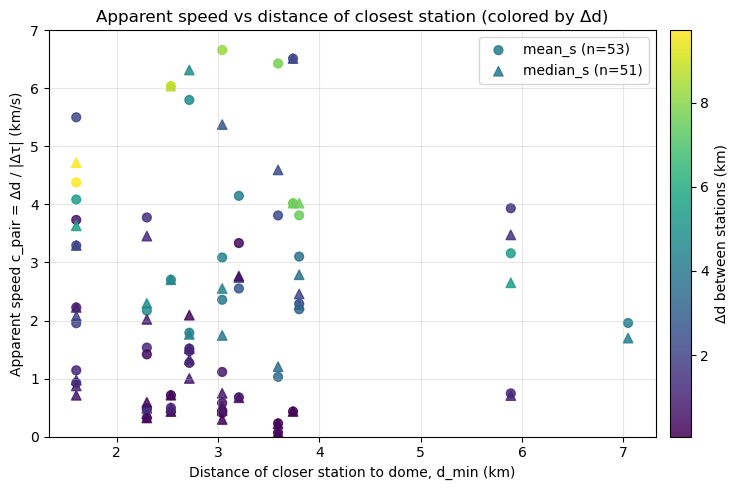

In [5]:
# --- Apparent speed vs distance of closest station, colored by Δd ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from flovopy.asl.distances import compute_or_load_distances

# Inputs already in your notebook:
# gridobj, INV, GLOBAL_CACHE (or CACHE_DIR), dome_location, OUTPUT_DIR
stable_csv = Path(OUTPUT_DIR) / "pairwise_lagdiff_stats_global_stable.csv"

stab = pd.read_csv(stable_csv)

# Ensure sta_a/sta_b exist and clean codes
def _clean_sta(x: str) -> str:
    import re
    return re.sub(r"[^A-Za-z0-9]", "", str(x)).upper()

if not {"sta_a", "sta_b"}.issubset(stab.columns):
    if "pair" not in stab.columns:
        raise ValueError("Need 'sta_a'/'sta_b' or a 'pair' column.")
    ab = stab["pair"].astype(str).str.split("-", n=1, expand=True)
    ab.columns = ["sta_a", "sta_b"]
    stab = pd.concat([stab, ab], axis=1)

stab["sta_a"] = stab["sta_a"].apply(_clean_sta)
stab["sta_b"] = stab["sta_b"].apply(_clean_sta)

# Distances from dome to each station
node_dists, coords, meta = compute_or_load_distances(
    gridobj,
    cache_dir=(GLOBAL_CACHE if 'GLOBAL_CACHE' in globals() else CACHE_DIR),
    inventory=INV, stream=None, use_elevation=True
)

def _to_sta_key(seed_or_sta: str) -> str:
    parts = str(seed_or_sta).split(".")
    return parts[1] if len(parts) >= 2 else str(seed_or_sta)

dist_by_sta = {}
for full_id, vec in node_dists.items():
    key = _to_sta_key(full_id)
    dist_by_sta.setdefault(key, np.asarray(vec, float))  # first channel wins

def _resolve_dome_idx(grid, dome):
    if isinstance(dome, int):
        return int(dome)
    glon = np.asarray(grid.gridlon).ravel()
    glat = np.asarray(grid.gridlat).ravel()
    if isinstance(dome, dict) and {"lon","lat"} <= set(dome):
        lon, lat = float(dome["lon"]), float(dome["lat"])
    elif isinstance(dome, (tuple, list)) and len(dome) == 2:
        lon, lat = float(dome[0]), float(dome[1])
    else:
        raise ValueError("dome_location must be node index, dict{'lon','lat'}, or (lon,lat).")
    return int(np.argmin((glon - lon)**2 + (glat - lat)**2))

dome_idx = _resolve_dome_idx(gridobj, dome_location)

# Build per-pair table, but use d_min_km = min(d_a, d_b)
def _per_pair(df: pd.DataFrame, use_value: str) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        a, b = r["sta_a"], r["sta_b"]
        if a not in dist_by_sta or b not in dist_by_sta:
            continue
        da_vec, db_vec = dist_by_sta[a], dist_by_sta[b]
        if not (np.isfinite(da_vec[dome_idx]) and np.isfinite(db_vec[dome_idx])):
            continue

        d_a = float(da_vec[dome_idx])
        d_b = float(db_vec[dome_idx])
        delta_d = abs(d_a - d_b)              # km
        d_min   = min(d_a, d_b)               # <- distance of the closer station

        if use_value not in r or not np.isfinite(r[use_value]):
            continue
        tau = float(r[use_value])
        if tau == 0:
            continue

        c = delta_d / abs(tau)                # km/s
        rows.append(dict(
            pair=f"{a}-{b}", sta_a=a, sta_b=b,
            delta_d_km=delta_d, d_min_km=d_min,
            delta_tau_s=abs(tau), c_pair_km_s=c
        ))
    return pd.DataFrame(rows)

pp_mean   = _per_pair(stab, "mean_s"   if "mean_s"   in stab.columns else "mean")
pp_median = _per_pair(stab, "median_s" if "median_s" in stab.columns else "median")

# Filter to physical speeds
C_MAX = 7.0
def _phys(df):
    m = (np.isfinite(df["c_pair_km_s"]) &
         np.isfinite(df["d_min_km"]) &
         np.isfinite(df["delta_d_km"]) &
         (df["c_pair_km_s"] <= C_MAX))
    return df.loc[m].copy()

pp_mean   = _phys(pp_mean)
pp_median = _phys(pp_median)

# Plot: apparent speed vs distance of closest station, colored by Δd
fig, ax = plt.subplots(figsize=(8, 5))

sc1 = ax.scatter(pp_mean["d_min_km"], pp_mean["c_pair_km_s"],
                 c=pp_mean["delta_d_km"], marker="o", s=40, alpha=0.85,
                 label=f"mean_s (n={len(pp_mean)})")
sc2 = ax.scatter(pp_median["d_min_km"], pp_median["c_pair_km_s"],
                 c=pp_median["delta_d_km"], marker="^", s=46, alpha=0.85,
                 label=f"median_s (n={len(pp_median)})")

cb = plt.colorbar(sc1, ax=ax, pad=0.02)
cb.set_label("Δd between stations (km)")

ax.set_xlabel("Distance of closer station to dome, d_min (km)")
ax.set_ylabel("Apparent speed c_pair = Δd / |Δτ| (km/s)")
ax.set_title("Apparent speed vs distance of closest station (colored by Δd)")
ax.grid(alpha=0.3)
ax.set_ylim(0, C_MAX)
ax.legend(loc="best")
plt.tight_layout()
plt.show()

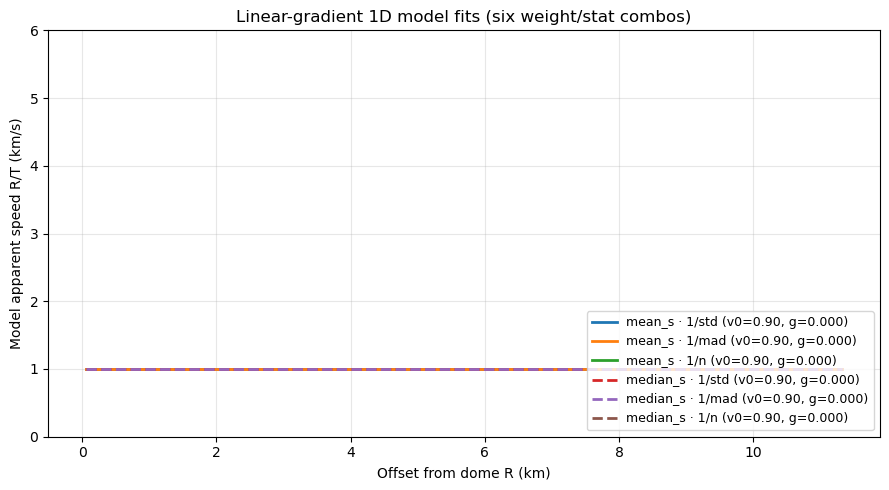

mean_s · 1/std (v0=0.90, g=0.000): v0=0.900 km/s, g=0.0000 s^-1  (n=67)
mean_s · 1/mad (v0=0.90, g=0.000): v0=0.900 km/s, g=0.0000 s^-1  (n=67)
mean_s · 1/n (v0=0.90, g=0.000): v0=0.900 km/s, g=0.0000 s^-1  (n=67)
median_s · 1/std (v0=0.90, g=0.000): v0=0.900 km/s, g=0.0000 s^-1  (n=67)
median_s · 1/mad (v0=0.90, g=0.000): v0=0.900 km/s, g=0.0000 s^-1  (n=67)
median_s · 1/n (v0=0.90, g=0.000): v0=0.900 km/s, g=0.0000 s^-1  (n=67)


In [15]:
# stable_glb is the DataFrame you already build (with sta_a, sta_b, mean_s, median_s, std, mad, n)
reload(envloc)
fits = envloc.run_six_and_plot(gridobj, INV, GLOBAL_CACHE, dome_location, stable_glb, cmax=6.0, v0_prior=(0.9, 0.3))

for f in fits:
    print(f"{f['label']}: v0={f['v0']:.3f} km/s, g={f['g']:.4f} s^-1  (n={f['n_pairs']})")

[build] kept 52 pairs, rejected 15
[build] kept 50 pairs, rejected 17
[fit] v0=2.780 km/s, beta=0.0000 (km/s)/km, R²=-0.028  (n=52)  [1/std, x=d_min_km]
[fit] v0=2.640 km/s, beta=0.0000 (km/s)/km, R²=-0.008  (n=52)  [1/mad, x=d_min_km]
[fit] v0=2.126 km/s, beta=0.0639 (km/s)/km, R²=-0.007  (n=52)  [1/n, x=d_min_km]
[fit] v0=2.309 km/s, beta=0.0000 (km/s)/km, R²=-0.009  (n=50)  [1/std, x=d_min_km]
[fit] v0=2.173 km/s, beta=0.0000 (km/s)/km, R²=-0.000  (n=50)  [1/mad, x=d_min_km]
[fit] v0=1.765 km/s, beta=0.1000 (km/s)/km, R²=0.002  (n=50)  [1/n, x=d_min_km]


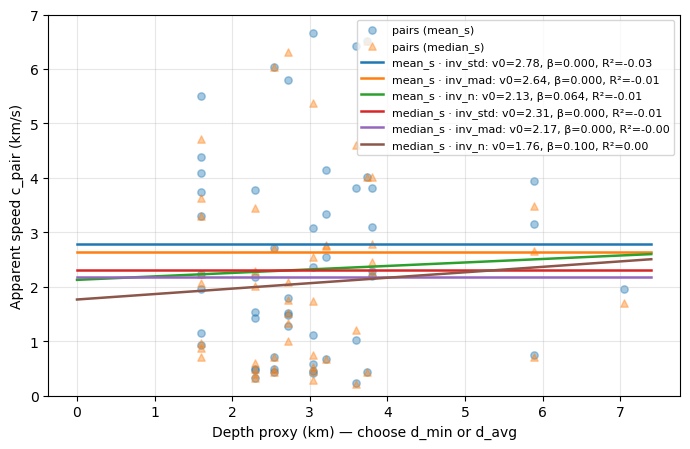

In [28]:
import matplotlib.pyplot as plt
reload(envloc)
from flovopy.asl.envelope_locate import *

stable_csv = f"{OUTPUT_DIR}/pairwise_lagdiff_stats_global_stable.csv"
stab = pd.read_csv(stable_csv)

# Build once for mean_s and once for median_s (adds d_min_km & d_avg_km)
pp_mean   = build_per_pair_from_stable(grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE,
                                       dome_location=dome_location, stable_df=stab, use_value="mean_s",
                                       c_bounds=(0.2, 7.0), verbose=True)
pp_median = build_per_pair_from_stable(grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE,
                                       dome_location=dome_location, stable_df=stab, use_value="median_s",
                                       c_bounds=(0.2, 7.0), verbose=True)

# Choose depth proxy on x-axis: "d_min_km" (closest station) or "d_avg_km" (average distance)
x_col = "d_min_km"

fits = []
for pp, stat_name in [(pp_mean, "mean_s"), (pp_median, "median_s")]:
    for wmode in ["inv_std", "inv_mad", "inv_n"]:
        res = fit_v0_beta_from_pairs(pp, x_col=x_col, weight_mode=wmode,
                                     v0_prior=None, beta_bounds=(0.0, 0.10),
                                     intercept_bounds=(0.2, 3.5), verbose=True)
        fits.append((stat_name, wmode, res))

# Plot the points and all 6 lines
fig, ax = plt.subplots(figsize=(7.0, 4.6))
ax.scatter(pp_mean[x_col], pp_mean["c_pair_km_s"], s=28, alpha=0.4, label="pairs (mean_s)")
ax.scatter(pp_median[x_col], pp_median["c_pair_km_s"], s=28, alpha=0.4, label="pairs (median_s)", marker="^")

xx = np.linspace(0, max(pp_mean[x_col].max(), pp_median[x_col].max())*1.05, 200)
for stat_name, wmode, res in fits:
    v0, beta, r2 = res["v0"], res["beta"], res["r2"]
    lbl = f"{stat_name} · {wmode}: v0={v0:.2f}, β={beta:.3f}, R²={r2:.2f}"
    ax.plot(xx, v0 + beta*xx, lw=1.8, label=lbl)

ax.set_xlabel("Depth proxy (km) — choose d_min or d_avg")
ax.set_ylabel("Apparent speed c_pair (km/s)")
ax.set_ylim(0, 7.0)
ax.grid(alpha=0.3)
ax.legend(fontsize=8, loc="best")
plt.tight_layout()
plt.show()

In [26]:
combos = [
    ("mean_s","inv_std"),
    ("mean_s","inv_mad"),
    ("mean_s","inv_n"),
    ("median_s","inv_std"),
    ("median_s","inv_mad"),
    ("median_s","inv_n"),
]
for use_val, wby in combos:
    out = envloc.fit_v0_beta_from_pairs(
        grid=gridobj, inventory=INV, cache_dir=GLOBAL_CACHE, dome_location=dome_location,
        stable_df=stable_glb, use_value=use_val, weight_by=wby,
        depth_proxy="avg",   # or "min"
        v0_prior=0.3, beta_prior=0.1,
    )
    print(f"{use_val} · {wby}: v0={out['v0_km_s']:.3f}, beta={out['beta_km_s_per_km']:.4f}, R²={out['r2']:.3f}, n={out['n']}")

[build] kept 67 pairs, rejected 0
[fit] v0=2.679 km/s, beta=0.2000 (km/s)/km, R²=-0.258  (n=67)
mean_s · inv_std: v0=2.679, beta=0.2000, R²=-0.258, n=67
[build] kept 67 pairs, rejected 0
[fit] v0=2.667 km/s, beta=0.2000 (km/s)/km, R²=-0.259  (n=67)
mean_s · inv_mad: v0=2.667, beta=0.2000, R²=-0.259, n=67
[build] kept 67 pairs, rejected 0
[fit] v0=2.880 km/s, beta=0.2000 (km/s)/km, R²=-0.251  (n=67)
mean_s · inv_n: v0=2.880, beta=0.2000, R²=-0.251, n=67
[build] kept 67 pairs, rejected 0
[fit] v0=2.705 km/s, beta=0.2000 (km/s)/km, R²=-0.412  (n=67)
median_s · inv_std: v0=2.705, beta=0.2000, R²=-0.412, n=67
[build] kept 67 pairs, rejected 0
[fit] v0=2.686 km/s, beta=0.2000 (km/s)/km, R²=-0.413  (n=67)
median_s · inv_mad: v0=2.686, beta=0.2000, R²=-0.413, n=67
[build] kept 67 pairs, rejected 0
[fit] v0=2.951 km/s, beta=0.2000 (km/s)/km, R²=-0.402  (n=67)
median_s · inv_n: v0=2.951, beta=0.2000, R²=-0.402, n=67
